# Point History Model Comparison

This notebook benchmarks every trained point-history model saved in `models/point_history` against the dynamic finger-trajectory dataset `data/point_history.csv` built from MediaPipe.

The workflow loads all `.tflite` and `.joblib` checkpoints (or trains new ones) and reports:

- Accuracy, macro F1, per-class precision/recall/F1, and the full classification report.
- Top-k accuracy, inference latency or throughput, disk size, estimated parameter count, and recorded training time.
- Robustness to additive trajectory noise.
- Confusion matrix visualizations, McNemar statistical tests, and focused analysis of circular versus linear gestures.

Adjust the configuration cell below to point at a different dataset, tweak the noise magnitude, or provide known training times.

*ENSURE all models are trained using the same dataset*

This run assumes the 5-class point-history dataset:
* 0 - Stop
* 1 - Clockwise circle
* 2 - Counter-clockwise circle
* 3 - Move (linear)
* 4 - Figure eight

In [89]:
import csv
import datetime
import re
import time
from itertools import count
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import joblib
import tensorflow as tf

from scipy.stats import chi2
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    top_k_accuracy_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

np.set_printoptions(linewidth=140, suppress=True)
pd.set_option("display.max_colwidth", None)

def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data").is_dir() and (candidate / "models").is_dir():
            return candidate
    raise RuntimeError("Could not locate the project root (data/ and models/ folders not found).")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_FILE = REPO_ROOT / "data" / "point_history.csv"
LABELS_FILE = REPO_ROOT / "data" / "point_history_labels.csv"
MODEL_DIR = REPO_ROOT / "models" / "point_history"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TIME_STEPS = 16
DIMENSION = 2
INPUT_DIM = TIME_STEPS * DIMENSION
TOP_K = 3
TOP_K_KEY = f"top_{TOP_K}_accuracy"
NOISE_STD = 0.015
RANDOM_SEED = 42
GESTURE_GROUPS = {
    "Circular": [1, 2, 4],
    "Static_vs_Move": [0, 3],
}

TRAINING_TIME_OVERRIDES = {
    # "joblib::point_history_classifier_LogisticRegression.joblib": 3.2,
    # "tflite::point_history_classifier_mlp.tflite": 120.0,
}

TRAIN_MODELS = True
TEST_SIZE = 0.25

TRAINED_JOBLIB_MODELS = []
TRAINED_TFLITE_MODELS = []
TRAINED_KERAS_MODELS = []
TRAINING_RUN_RECORDS = []
ARTIFACT_COUNTER = count()

rng = np.random.default_rng(RANDOM_SEED)

JOBLIB_MODELS = []
TFLITE_MODELS = []
KERAS_MODELS = []

print(f"TensorFlow version: {tf.__version__}")
print(f"Repo root: {REPO_ROOT}")
print(f"Dataset: {DATA_FILE}")
print(f"Models directory: {MODEL_DIR}")
print(f"Training enabled: {TRAIN_MODELS}")


TensorFlow version: 2.19.1
Repo root: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition
Dataset: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\data\point_history.csv
Models directory: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history
Training enabled: True


In [90]:
def load_label_map(path: Path):
    mapping = {}
    with path.open(encoding="utf-8-sig") as f:
        reader = csv.reader(f)
        for idx, row in enumerate(reader):
            if not row:
                continue
            raw = row[0].strip()
            digits = "".join(ch for ch in raw if ch.isdigit())
            label_id = int(digits) if digits else idx
            label_name = raw[: len(raw) - len(digits)] or raw
            mapping[label_id] = label_name
    return mapping

label_map = load_label_map(LABELS_FILE)
label_ids_sorted = sorted(label_map.keys())
label_names_sorted = [label_map[i] for i in label_ids_sorted]

df = pd.read_csv(DATA_FILE, header=None)
print(f"Dataset shape: {df.shape} (rows x columns)")
display(df.head())

X = df.iloc[:, 1:].to_numpy(dtype=np.float32)
y = df.iloc[:, 0].astype(int).to_numpy()

X_noise = (X + rng.normal(loc=0.0, scale=NOISE_STD, size=X.shape)).astype(np.float32)

print(f"Feature matrix: {X.shape}, Labels: {y.shape}, Unique classes: {sorted(np.unique(y))}")
print(f"Noise std applied to trajectories: {NOISE_STD}")


Dataset shape: (7185, 33) (rows x columns)


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0.0,0.0,-0.002083,-0.003704,-0.002083,-0.003704,-0.003125,-0.005556,-0.002083,...,-0.003125,-0.016667,-0.002083,-0.018519,-0.002083,-0.016667,-0.001042,-0.016667,0.000000,-0.014815
1,0,0.0,0.0,0.001042,0.000000,0.002083,0.000000,0.001042,0.001852,0.002083,...,-0.001042,0.003704,-0.001042,0.003704,-0.001042,0.001852,-0.002083,0.005556,-0.002083,0.005556
2,0,0.0,0.0,0.001042,0.000000,0.000000,0.001852,0.001042,0.001852,0.001042,...,-0.002083,0.003704,-0.002083,0.001852,-0.003125,0.005556,-0.003125,0.005556,-0.002083,0.007407
3,0,0.0,0.0,-0.001042,0.001852,0.000000,0.001852,0.000000,0.001852,0.000000,...,-0.003125,0.001852,-0.004167,0.005556,-0.004167,0.005556,-0.003125,0.007407,-0.004167,0.007407
4,0,0.0,0.0,0.001042,0.000000,0.001042,0.000000,0.001042,0.000000,0.002083,...,-0.003125,0.003704,-0.003125,0.003704,-0.002083,0.005556,-0.003125,0.005556,-0.002083,0.005556


Feature matrix: (7185, 32), Labels: (7185,), Unique classes: [0, 1, 2, 3, 4]
Noise std applied to trajectories: 0.015


In [91]:
NUM_FEATURES = X.shape[1]
if NUM_FEATURES != INPUT_DIM:
    print(f"Warning: expected {INPUT_DIM} features but found {NUM_FEATURES}")
NUM_CLASSES = len(label_ids_sorted)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y,
)

print(f"Train split: {X_train_split.shape}, Validation split: {X_val_split.shape}")
print(f"Class distribution (train): {np.bincount(y_train_split, minlength=NUM_CLASSES)}")
print(f"Class distribution (val):   {np.bincount(y_val_split, minlength=NUM_CLASSES)}")


Train split: (5388, 32), Validation split: (1797, 32)
Class distribution (train): [1111  925  959  976 1417]
Class distribution (val):   [370 309 320 326 472]


## Unified Training Pipelines

The next cells consolidate the end-to-end training flows from the dedicated notebooks:

- `point_history_training.ipynb` (MLP + LSTM time-history classifiers)
- `keypoint_models_comparison_analysis.ipynb` (classical baselines, TFLite/graph transformers, and XGBoost)

Running this section retrains every model variant, saves the resulting checkpoints inside `models/point_history`, and records metrics so the comparison stage can immediately benchmark the fresh outputs.

In [92]:
def register_tflite_model(display_name, alias, keras_model, train_time, metrics=None, quantize=True, allow_select_tf_ops=False, disable_lower_tensor_list=False):
    slug = slugify_name(alias or display_name)
    suffix = next_artifact_suffix()
    keras_path = MODEL_DIR / f"point_history_classifier_{slug}_{suffix}.keras"
    keras_model.save(keras_path, include_optimizer=False)

    def convert_model(enable_select_ops, disable_tensor_list, quantize_flag):
        converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
        if quantize_flag:
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
        if enable_select_ops:
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS,
            ]
            converter.allow_custom_ops = True
        if disable_tensor_list:
            for attr in ("_experimental_lower_tensor_list_ops", "experimental_lower_tensor_list_ops"):
                if hasattr(converter, attr):
                    setattr(converter, attr, False)
        if hasattr(converter, "experimental_new_converter"):
            converter.experimental_new_converter = True
        return converter.convert()

    tflite_buffer = None
    tflite_path = None
    try:
        tflite_buffer = convert_model(allow_select_tf_ops, disable_lower_tensor_list, quantize)
    except Exception as convert_err:
        needs_retry = not (allow_select_tf_ops and disable_lower_tensor_list)
        if not needs_retry:
            print("TFLite conversion failed even with Select TF ops enabled; skipping TFLite export for", display_name)
            print(convert_err)
        else:
            print("Retrying TFLite conversion with Select TF ops and tensor-list lowering disabled due to: {}".format(convert_err))
            try:
                tflite_buffer = convert_model(True, True, False)
            except Exception as retry_err:
                print("Retry also failed; skipping TFLite export for", display_name)
                print(retry_err)
            else:
                tflite_path = MODEL_DIR / f"point_history_classifier_{slug}_{suffix}.tflite"
    else:
        tflite_path = MODEL_DIR / f"point_history_classifier_{slug}_{suffix}.tflite"

    if tflite_buffer is not None and tflite_path is not None:
        with tflite_path.open("wb") as f:
            f.write(tflite_buffer)
        TRAINED_TFLITE_MODELS.append(tflite_path)
        TRAINING_TIME_OVERRIDES[f"tflite::{tflite_path.name}"] = float(train_time)
        log_training_record(display_name, "tflite", tflite_path, train_time, metrics)
    else:
        log_training_record(display_name, "keras_only", keras_path, train_time, metrics)

    return keras_path, tflite_path


In [93]:

def register_keras_model(display_name, alias, keras_model, train_time, metrics=None):
    slug = slugify_name(alias or display_name)
    suffix = next_artifact_suffix()
    keras_path = MODEL_DIR / f"point_history_classifier_{slug}_{suffix}.keras"
    keras_model.save(keras_path, include_optimizer=False)
    TRAINED_KERAS_MODELS.append(keras_path)
    TRAINING_TIME_OVERRIDES[f"keras::{keras_path.name}"] = float(train_time)
    log_training_record(display_name, "keras", keras_path, train_time, metrics)
    return keras_path


In [94]:
def train_classical_baselines(X_train, y_train, X_val, y_val):
    print("Training classical ML baselines...")
    models = {
        "LinearSVC": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC(
                C=1.0,
                loss="squared_hinge",
                random_state=RANDOM_SEED,
                dual=False,
            )),
        ]),
        "LogisticRegression": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                multi_class="multinomial",
                solver="lbfgs",
                max_iter=1000,
                random_state=RANDOM_SEED,
            )),
        ]),
        "KNeighbors": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(
                n_neighbors=5,
                weights="distance",
                metric="minkowski",
            )),
        ]),
        "SVC_RBF": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=True,
                random_state=RANDOM_SEED,
            )),
        ]),
        "RandomForest": RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
    }

    artifacts = []
    for name, estimator in models.items():
        start = time.perf_counter()
        estimator.fit(X_train, y_train)
        duration = time.perf_counter() - start
        y_pred = estimator.predict(X_val)
        acc, macro_f1 = evaluate_split_metrics(y_val, y_pred)
        metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
        path = register_joblib_model(f"Baseline::{name}", name, estimator, duration, metrics)
        print(f"  {name:15s} | acc={acc:.4f} macro F1={macro_f1:.4f} | saved→{path.name}")
        artifacts.append((name, path))
    return artifacts


In [95]:
def build_mlp_baseline(input_dim, num_classes):
    return tf.keras.Sequential([
        tf.keras.layers.Input((input_dim,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ], name="mlp_point_history_classifier")

def build_lstm_classifier(time_steps, point_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input((time_steps * point_dim,)),
        tf.keras.layers.Reshape((time_steps, point_dim)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ], name="lstm_point_history_classifier")
    return model


def train_mlp_classifier(X_train, y_train, X_val, y_val):
    print("Training MLP baseline (Keras)...")
    reset_tf_session()
    model = build_mlp_baseline(X_train.shape[1], NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, verbose=1)
    ]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=400,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    keras_path, tflite_path = register_tflite_model("MLP", "mlp", model, duration, metrics)
    print(f"  MLP validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return keras_path, tflite_path


def train_lstm_classifier(X_train, y_train, X_val, y_val):
    print("Training LSTM sequence model (Keras)...")
    reset_tf_session()
    model = build_lstm_classifier(TIME_STEPS, DIMENSION, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=400,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    keras_path = register_keras_model("LSTM", "lstm", model, duration, metrics)
    print(f"  LSTM validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{keras_path.name}")
    return keras_path, None


In [96]:
TIME_CONNECTIONS = [(i, i + 1) for i in range(TIME_STEPS - 1)]

def build_adjacency_matrix(num_nodes, connections):
    adj = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    for i, j in connections:
        adj[i, j] = 1.0
        adj[j, i] = 1.0
    np.fill_diagonal(adj, 1.0)
    return adj

GRAPH_ADJ = build_adjacency_matrix(TIME_STEPS, TIME_CONNECTIONS)


class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, adjacency_matrix, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self._adjacency_matrix_for_config = adjacency_matrix
        self.adj = tf.constant(adjacency_matrix, dtype=tf.float32)
        self.graph_bias_weight = self.add_weight(
            name="graph_bias_weight",
            shape=(),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        bias = self.adj * self.graph_bias_weight
        bias = tf.expand_dims(bias, axis=0)
        bias = tf.expand_dims(bias, axis=1)
        return self.mha(x, x, attention_mask=bias)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "adjacency_matrix": self._adjacency_matrix_for_config.tolist(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        config["adjacency_matrix"] = np.array(config["adjacency_matrix"], dtype=np.float32)
        return cls(**config)


def build_graph_transformer(adjacency_matrix, num_steps, step_dim, num_classes,
                            d_model=64, num_heads=4, ff_multiplier=2, num_layers=2,
                            dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(num_steps * step_dim,), name="flat_input")
    x = tf.keras.layers.Reshape((num_steps, step_dim), name="reshape_tokens")(inputs)
    x = tf.keras.layers.Dense(d_model, name="token_projection")(x)
    step_ids = tf.range(num_steps)
    step_emb = tf.keras.layers.Embedding(input_dim=num_steps, output_dim=d_model)(step_ids)
    x = tf.keras.layers.Add(name="add_step_id")([x, tf.expand_dims(step_emb, axis=0)])

    for idx in range(num_layers):
        res = x
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{idx}")(x)
        x = GraphAttentionLayer(num_heads=num_heads,
                                key_dim=d_model // num_heads,
                                adjacency_matrix=adjacency_matrix,
                                name=f"graph_attn_{idx}")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Add(name=f"res1_{idx}")([res, x])

        res = x
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{idx}")(x)
        x = tf.keras.layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(d_model)(x)
        x = tf.keras.layers.Add(name=f"res2_{idx}")([res, x])

    pooled = tf.keras.layers.GlobalAveragePooling1D(name="gap")(x)
    pooled = tf.keras.layers.Dropout(dropout_rate)(pooled)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification_head")(pooled)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="TemporalGraphTransformer")


def train_graph_transformer(X_train, y_train, X_val, y_val):
    print("Training graph-aware Transformer...")
    reset_tf_session()
    model = build_graph_transformer(GRAPH_ADJ, TIME_STEPS, DIMENSION, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32), y_train,
        epochs=400,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    _, tflite_path = register_tflite_model("GraphTransformer", "graph_transformer", model, duration, metrics)
    print(f"  Graph Transformer validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return tflite_path


In [97]:
def build_transformer_classifier(num_steps, step_dim, num_classes,
                                 d_model=64, num_heads=4, ff_multiplier=2,
                                 num_layers=2, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(num_steps * step_dim,))
    x = tf.keras.layers.Reshape((num_steps, step_dim))(inputs)
    x = tf.keras.layers.Dense(d_model)(x)

    for _ in range(num_layers):
        attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = tf.keras.layers.Add()([x, attn])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        ff = tf.keras.layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        ff = tf.keras.layers.Dense(d_model)(ff)
        ff = tf.keras.layers.Dropout(dropout_rate)(ff)
        x = tf.keras.layers.Add()([x, ff])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_self_attention")


def train_self_attention_transformer(X_train, y_train, X_val, y_val):
    print("Training Transformer self-attention model...")
    reset_tf_session()
    model = build_transformer_classifier(TIME_STEPS, DIMENSION, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32), y_train,
        epochs=400,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    _, tflite_path = register_tflite_model("TransformerSelfAttention", "transformer_self_attention", model, duration, metrics)
    print(f"  Transformer validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return tflite_path


In [98]:
def train_xgboost_classifier(X_train, y_train, X_val, y_val):
    print("Training XGBoost classifier with grid search...")
    num_classes = len(np.unique(y_train))
    base_params = dict(
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_SEED,
        n_jobs=-1,
    )
    param_grid = {
        "max_depth": [2, 4],
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    estimator = XGBClassifier(**base_params)
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    start = time.perf_counter()
    grid.fit(X_train, y_train)
    duration = time.perf_counter() - start
    best_model = grid.best_estimator_
    print(f"  Best params: {grid.best_params_} | CV accuracy={grid.best_score_:.4f}")
    y_pred = best_model.predict(X_val)
    acc, macro_f1 = evaluate_split_metrics(y_val, y_pred)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    path = register_joblib_model("XGBoost", "xgboost", best_model, duration, metrics)
    print(f"  XGBoost validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{path.name}")
    return path


In [99]:
if TRAIN_MODELS:
    TRAINED_JOBLIB_MODELS.clear()
    TRAINED_TFLITE_MODELS.clear()
    TRAINING_RUN_RECORDS.clear()

    baseline_artifacts = train_classical_baselines(X_train_split, y_train_split, X_val_split, y_val_split)
    mlp_artifacts = train_mlp_classifier(X_train_split, y_train_split, X_val_split, y_val_split)
    lstm_artifact = train_lstm_classifier(X_train_split, y_train_split, X_val_split, y_val_split)
    graph_artifact = train_graph_transformer(X_train_split, y_train_split, X_val_split, y_val_split)
    self_attn_artifact = train_self_attention_transformer(X_train_split, y_train_split, X_val_split, y_val_split)
    xgb_artifact = train_xgboost_classifier(X_train_split, y_train_split, X_val_split, y_val_split)

    print("Finished training all model families.")
else:
    print("Training disabled via TRAIN_MODELS flag – skipping model retraining.")


Training classical ML baselines...
  LinearSVC       | acc=0.2142 macro F1=0.0719 | saved→point_history_classifier_linearsvc_20251121_014943_00.joblib
  LogisticRegression | acc=0.2159 macro F1=0.0734 | saved→point_history_classifier_logisticregression_20251121_014943_01.joblib
  KNeighbors      | acc=0.9655 macro F1=0.9668 | saved→point_history_classifier_kneighbors_20251121_014943_02.joblib


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  SVC_RBF         | acc=0.9060 macro F1=0.9110 | saved→point_history_classifier_svc_rbf_20251121_014945_03.joblib
  RandomForest    | acc=0.9839 macro F1=0.9846 | saved→point_history_classifier_randomforest_20251121_014946_04.joblib
Training MLP baseline (Keras)...
Epoch 1/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1639 - loss: 1.6003 - val_accuracy: 0.2198 - val_loss: 1.5761
Epoch 2/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2129 - loss: 1.5622 - val_accuracy: 0.2627 - val_loss: 1.5388
Epoch 3/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2576 - loss: 1.5225 - val_accuracy: 0.2627 - val_loss: 1.4937
Epoch 4/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2630 - loss: 1.4832 - val_accuracy: 0.2627 - val_loss: 1.4534
Epoch 5/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3940 - loss: 1.4535 - val_accuracy: 0.4302 - val_loss: 1.4196
Epoch 6/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4395 - loss: 1.4172 - val_accuracy

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpxctlx0dz\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmpxctlx0dz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2561579111952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579111184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579119440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579122128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579109648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579109264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  MLP validation accuracy=0.8631, macro F1=0.8656 | saved→point_history_classifier_mlp_20251121_015029_05.tflite
Training LSTM sequence model (Keras)...
Epoch 1/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1960 - loss: 1.6022 - val_accuracy: 0.2627 - val_loss: 1.5887
Epoch 2

c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['graph_attn_0/graph_bias_weight', 'graph_attn_1/graph_bias_weight'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4761 - loss: 1.2706 - val_accuracy: 0.5927 - val_loss: 0.9664
Epoch 2/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5980 - loss: 0.9636 - val_accuracy: 0.6138 - val_loss: 0.8733
Epoch 3/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6295 - loss: 0.8692 - val_accuracy: 0.6316 - val_loss: 0.8238
Epoch 4/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6505 - loss: 0.8193 - val_accuracy: 0.6850 - val_loss: 0.7396
Epoch 5/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6832 - loss: 0.7556 - val_accuracy: 0.7129 - val_loss: 0.6956
Epoch 6/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7027 - loss: 0.7234 - val_accuracy: 0.7040 - val_loss: 0.7016
Epoch 7/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7313 - loss: 0.6742 - val_accuracy: 0.6639 - val_loss: 0.8483
Epoch 8/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7322 - loss: 0.6766 - val_accuracy: 0.7201 - val_l

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmplqq0zmy6\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmplqq0zmy6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='flat_input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2561579116176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579120400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579119632: TensorSpec(shape=(1, 16, 64), dtype=tf.float32, name=None)
  2561579122320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579115408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579121744: TensorSpec(shape=(16, 16), dtype=tf.float32, name=None)
  2561780320976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561780334032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561780327696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561780326544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  256

INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpaalrplpe\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmpaalrplpe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2561579113488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579115024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579115216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579114832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561579114448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561652954064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561652953680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561652956560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561652954256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2561652955600:

In [100]:
if TRAINING_RUN_RECORDS:
    training_df = pd.DataFrame(TRAINING_RUN_RECORDS)
    display(training_df.sort_values(by=["val_macro_f1", "val_accuracy"], ascending=False, na_position="last"))
else:
    print("No new training records captured in this session.")


,model_name,artifact_type,artifact_path,train_time_s,val_accuracy,val_macro_f1
4,Baseline::RandomForest,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_randomforest_20251121_014946_04.joblib,0.682276,0.983862,0.984557
8,TransformerSelfAttention,tflite,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_transformer_self_attention_20251121_015810_08.tflite,171.304270,0.980523,0.979472
9,XGBoost,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_xgboost_20251121_015824_09.joblib,11.714263,0.976628,0.977133
2,Baseline::KNeighbors,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_kneighbors_20251121_014943_02.joblib,0.002980,0.965498,0.966845
7,GraphTransformer,tflite,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_graph_transformer_20251121_015515_07.tflite,143.676344,0.938787,0.944362
3,Baseline::SVC_RBF,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_svc_rbf_20251121_014945_03.joblib,1.964263,0.905954,0.910973
6,LSTM,keras,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_lstm_20251121_015250_06.keras,139.059242,0.903728,0.909771
5,MLP,tflite,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_mlp_20251121_015029_05.tflite,41.974416,0.863105,0.865581
1,Baseline::LogisticRegression,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_logisticregression_20251121_014943_01.joblib,0.067984,0.215915,0.073381
0,Baseline::LinearSVC,joblib,c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\models\point_history\point_history_classifier_linearsvc_20251121_014943_00.joblib,0.101448,0.214246,0.071912


In [101]:
if TRAINED_JOBLIB_MODELS or TRAINED_TFLITE_MODELS or TRAINED_KERAS_MODELS:
    JOBLIB_MODELS = TRAINED_JOBLIB_MODELS
    TFLITE_MODELS = TRAINED_TFLITE_MODELS
    KERAS_MODELS = TRAINED_KERAS_MODELS
else:
    JOBLIB_MODELS = sorted(MODEL_DIR.glob("*.joblib"))
    TFLITE_MODELS = sorted(MODEL_DIR.glob("*.tflite"))
    keras_candidates = sorted(MODEL_DIR.glob("*.keras"))
    KERAS_MODELS = []
    for path_candidate in keras_candidates:
        has_tflite = path_candidate.with_suffix(".tflite").exists()
        if not has_tflite:
            KERAS_MODELS.append(path_candidate)

print(f"Detected {len(JOBLIB_MODELS)} joblib, {len(TFLITE_MODELS)} TFLite, and {len(KERAS_MODELS)} Keras models for evaluation.")


Detected 6 joblib, 3 TFLite, and 1 Keras models for evaluation.


In [102]:
def describe_label(label_id):
    return f"{label_id}: {label_map.get(label_id, str(label_id))}"

def format_labels(label_ids):
    return [describe_label(idx) for idx in label_ids]

def compute_custom_metrics(y_true, y_pred, similar_group):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    relaxed_correct = []
    for t, p in zip(y_true, y_pred):
        if t in similar_group:
            relaxed_correct.append(p in similar_group)
        else:
            relaxed_correct.append(p == t)
    relaxed_accuracy = float(np.mean(relaxed_correct))
    return relaxed_accuracy

def mcnemars_test(y_true, y_pred_a, y_pred_b):
    y_true = np.asarray(y_true)
    y_pred_a = np.asarray(y_pred_a)
    y_pred_b = np.asarray(y_pred_b)

    correct_a = y_pred_a == y_true
    correct_b = y_pred_b == y_true

    b = np.sum(correct_a & ~correct_b)
    c = np.sum(~correct_a & correct_b)
    n = b + c
    if n == 0:
        return np.nan, np.nan, b, c

    chi2_stat = (abs(b - c) - 1) ** 2 / n
    p_value = chi2.sf(chi2_stat, df=1)
    return chi2_stat, p_value, b, c

def plot_confusion_matrix(cm, label_strings, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(label_strings)))
    ax.set_yticks(range(len(label_strings)))
    ax.set_xticklabels(label_strings, rotation=45, ha="right")
    ax.set_yticklabels(label_strings)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_title(title)

    thresh = cm.max() / 2.0 if cm.any() else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    plt.show()

def plot_two_confusion_matrices(cm_a, labels_a, name_a, cm_b, labels_b, name_b):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, cm, labels, title in zip(
        axes,
        [cm_a, cm_b],
        [labels_a, labels_b],
        [name_a, name_b],
    ):
        im = ax.imshow(cm, cmap="Blues")
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticklabels(labels)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")
        ax.set_title(title)
        thresh = cm.max() / 2.0 if cm.any() else 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j,
                    i,
                    cm[i, j],
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.tight_layout()
    plt.show()

def estimate_parameter_count(model):
    seen = set()
    total = 0
    stack = [model]
    while stack:
        obj = stack.pop()
        if obj is None:
            continue
        obj_id = id(obj)
        if obj_id in seen:
            continue
        seen.add(obj_id)

        if isinstance(obj, np.ndarray):
            total += obj.size
            continue
        if isinstance(obj, (list, tuple, set)):
            stack.extend(obj)
            continue
        if isinstance(obj, dict):
            stack.extend(obj.values())
            continue

        for attr in (
            "coef_",
            "intercept_",
            "support_vectors_",
            "dual_coef_",
            "rho_",
            "feature_importances_",
            "estimators_",
            "tree_",
            "value",
        ):
            if hasattr(obj, attr):
                stack.append(getattr(obj, attr))

        if hasattr(obj, "__dict__"):
            stack.extend(obj.__dict__.values())
    return int(total) if total else np.nan

def measure_joblib_training_time(model, X_train, y_train):
    try:
        estimator = clone(model)
    except Exception:
        return np.nan, "clone_failed"

    start = time.perf_counter()
    try:
        estimator.fit(X_train, y_train)
    except Exception:
        return np.nan, "fit_failed"
    elapsed = time.perf_counter() - start
    return float(elapsed), "measured_fit"


In [103]:
def safe_top_k_accuracy(y_true, score_matrix, score_labels, k):
    if score_matrix is None or score_labels is None:
        return np.nan
    score_labels = np.asarray(score_labels)
    if score_matrix.shape[1] != len(score_labels):
        return np.nan
    y_true = np.asarray(y_true)
    mask = np.isin(y_true, score_labels)
    if not np.any(mask):
        return np.nan
    filtered_scores = score_matrix[mask]
    filtered_true = y_true[mask]
    return top_k_accuracy_score(filtered_true, filtered_scores, k=k, labels=score_labels)

def get_joblib_scores(model, X_data, y_true, labels, top_k):
    start = time.perf_counter()
    y_pred = model.predict(X_data)
    elapsed = time.perf_counter() - start
    latency_ms = (elapsed / len(X_data)) * 1000.0
    samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf

    y_proba = None
    proba_labels = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_data)
        proba_labels = getattr(model, "classes_", None)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_data)
        scores = np.asarray(scores)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
        y_proba = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        proba_labels = getattr(model, "classes_", None)

    topk_acc = safe_top_k_accuracy(y_true, y_proba, proba_labels, top_k)
    return y_pred, y_proba, topk_acc, latency_ms, samples_per_second

def evaluate_joblib_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"joblib::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    model = joblib.load(model_path)

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    y_pred, y_proba, topk_acc, latency_ms, sps = get_joblib_scores(
        model, X_eval, y_eval, labels, TOP_K
    )
    y_pred_noise, _, _, _, _ = get_joblib_scores(
        model, X_eval_noise, y_eval, labels, TOP_K
    )

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    group_metrics = {}
    for group_name, group_ids in GESTURE_GROUPS.items():
        relaxed_acc = compute_custom_metrics(y_eval, y_pred, group_ids)
        group_metrics[f"relaxed_acc_{group_name}"] = relaxed_acc

    model_disk_mb = model_path.stat().st_size / (1024**2)
    param_count = estimate_parameter_count(model)

    training_time_s, training_time_source = measure_joblib_training_time(model, X, y)
    if np.isnan(training_time_s):
        training_time_s = TRAINING_TIME_OVERRIDES.get(name, np.nan)
        if not np.isnan(training_time_s):
            training_time_source = "override"

    result = {
        "model_name": name,
        "model_type": "joblib",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        **group_metrics,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"
    param_display = "N/A" if np.isnan(param_count) else f"{int(param_count):,}"

    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB | Parameters≈{param_display}")
    print(f"  Noise ({NOISE_STD} sigma) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    for group_name in GESTURE_GROUPS:
        print(f"  Relaxed Acc ({group_name})={group_metrics[f'relaxed_acc_{group_name}']:.4f}")

    return name, result

def evaluate_tflite_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"tflite::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    interpreter = tf.lite.Interpreter(model_path=str(model_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    input_index = input_details["index"]
    output_index = output_details["index"]
    input_dtype = input_details["dtype"]

    def run_inference(X_data):
        preds = []
        outputs = []
        start = time.perf_counter()
        for row in X_data:
            tensor = np.expand_dims(row, axis=0).astype(input_dtype)
            interpreter.set_tensor(input_index, tensor)
            interpreter.invoke()
            out = interpreter.get_tensor(output_index)
            outputs.append(out[0])
            preds.append(int(np.argmax(out)))
        elapsed = time.perf_counter() - start
        latency_ms = (elapsed / len(X_data)) * 1000.0
        samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf
        outputs = np.asarray(outputs, dtype=np.float32)
        exp_scores = np.exp(outputs - outputs.max(axis=1, keepdims=True))
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return np.array(preds), probs, latency_ms, samples_per_second

    y_pred, y_proba, latency_ms, sps = run_inference(X_eval)
    y_pred_noise, _, _, _ = run_inference(X_eval_noise)

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    group_metrics = {}
    for group_name, group_ids in GESTURE_GROUPS.items():
        relaxed_acc = compute_custom_metrics(y_eval, y_pred, group_ids)
        group_metrics[f"relaxed_acc_{group_name}"] = relaxed_acc

    topk_acc = safe_top_k_accuracy(y_eval, y_proba, labels, TOP_K)
    model_disk_mb = model_path.stat().st_size / (1024**2)
    param_count = np.nan
    training_time_s = TRAINING_TIME_OVERRIDES.get(name, np.nan)
    training_time_source = "override" if name in TRAINING_TIME_OVERRIDES else "unknown"

    result = {
        "model_name": name,
        "model_type": "tflite",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        **group_metrics,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"

    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB")
    print(f"  Noise ({NOISE_STD} sigma) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    for group_name in GESTURE_GROUPS:
        print(f"  Relaxed Acc ({group_name})={group_metrics[f'relaxed_acc_{group_name}']:.4f}")

    return name, result


def evaluate_keras_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"keras::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    model = tf.keras.models.load_model(model_path)

    def run_inference(X_data):
        start = time.perf_counter()
        outputs = model.predict(X_data.astype(np.float32), batch_size=256, verbose=0)
        elapsed = time.perf_counter() - start
        latency_ms = (elapsed / len(X_data)) * 1000.0
        samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf
        return outputs, latency_ms, samples_per_second

    logits, latency_ms, sps = run_inference(X_eval)
    logits_noise, _, _ = run_inference(X_eval_noise)

    y_pred = np.argmax(logits, axis=1)
    y_pred_noise = np.argmax(logits_noise, axis=1)
    y_proba = tf.nn.softmax(logits, axis=1).numpy()

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    group_metrics = {}
    for group_name, group_ids in GESTURE_GROUPS.items():
        relaxed_acc = compute_custom_metrics(y_eval, y_pred, group_ids)
        group_metrics[f"relaxed_acc_{group_name}"] = relaxed_acc

    topk_acc = safe_top_k_accuracy(y_eval, y_proba, labels, TOP_K)
    model_disk_mb = model_path.stat().st_size / (1024**2)
    try:
        param_count = model.count_params()
    except Exception:
        param_count = np.nan
    training_time_key = f"keras::{model_path.name}"
    training_time_s = TRAINING_TIME_OVERRIDES.get(training_time_key, np.nan)
    training_time_source = "override" if training_time_key in TRAINING_TIME_OVERRIDES else "unknown"

    result = {
        "model_name": name,
        "model_type": "keras",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        **group_metrics,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"
    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB | Parameters≈{param_count if not np.isnan(param_count) else 'N/A'}")
    print(f"  Noise ({NOISE_STD} sigma) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    for group_name in GESTURE_GROUPS:
        print(f"  Relaxed Acc ({group_name})={group_metrics[f'relaxed_acc_{group_name}']:.4f}")

    return name, result


In [104]:
all_results = {}
all_predictions = {}

for model_path in JOBLIB_MODELS:
    name, res = evaluate_joblib_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

for model_path in TFLITE_MODELS:
    name, res = evaluate_tflite_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

for model_path in KERAS_MODELS:
    name, res = evaluate_keras_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

if not all_results:
    raise RuntimeError("No models were evaluated. Please add .joblib, .tflite, or .keras files to models/point_history.")



📦 Evaluating joblib::point_history_classifier_linearsvc_20251121_014943_00.joblib
  Accuracy=0.2283 | Macro F1=0.0773 | Top-3 Acc=0.6644
  Latency=0.0011 ms/sample | Speed=892081.15 samples/s
  Disk size=0.003 MB | Parameters≈266
  Noise (0.015 sigma) -> acc=0.2239, macro F1=0.0752
  Relaxed Acc (Circular)=0.5786
  Relaxed Acc (Static_vs_Move)=0.2316

📦 Evaluating joblib::point_history_classifier_logisticregression_20251121_014943_01.joblib
  Accuracy=0.2299 | Macro F1=0.0782 | Top-3 Acc=0.6668
  Latency=0.0005 ms/sample | Speed=2117470.24 samples/s
  Disk size=0.003 MB | Parameters≈267
  Noise (0.015 sigma) -> acc=0.2263, macro F1=0.0768
  Relaxed Acc (Circular)=0.5804
  Relaxed Acc (Static_vs_Move)=0.2328

📦 Evaluating joblib::point_history_classifier_kneighbors_20251121_014943_02.joblib


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Accuracy=0.9879 | Macro F1=0.9885 | Top-3 Acc=0.9993
  Latency=0.0092 ms/sample | Speed=108228.86 samples/s
  Disk size=0.701 MB | Parameters≈177,905
  Noise (0.015 sigma) -> acc=0.9457, macro F1=0.9505
  Relaxed Acc (Circular)=0.9900
  Relaxed Acc (Static_vs_Move)=0.9879

📦 Evaluating joblib::point_history_classifier_svc_rbf_20251121_014945_03.joblib
  Accuracy=0.9271 | Macro F1=0.9317 | Top-3 Acc=0.9976
  Latency=0.1592 ms/sample | Speed=6281.29 samples/s
  Disk size=0.604 MB | Parameters≈79,916
  Noise (0.015 sigma) -> acc=0.9265, macro F1=0.9308
  Relaxed Acc (Circular)=0.9356
  Relaxed Acc (Static_vs_Move)=0.9351

📦 Evaluating joblib::point_history_classifier_randomforest_20251121_014946_04.joblib
  Accuracy=0.9928 | Macro F1=0.9931 | Top-3 Acc=1.0000
  Latency=0.0165 ms/sample | Speed=60460.51 samples/s
  Disk size=17.629 MB | Parameters≈4,304
  Noise (0.015 sigma) -> acc=0.8327, macro F1=0.8299
  Relaxed Acc (Circular)=0.9942
  Relaxed Acc (Static_vs_Move)=0.9928

📦 Evaluating

c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.8628 | Macro F1=0.8651 | Top-3 Acc=0.9992
  Latency=0.0119 ms/sample | Speed=84099.91 samples/s
  Disk size=0.006 MB
  Noise (0.015 sigma) -> acc=0.8333, macro F1=0.8358
  Relaxed Acc (Circular)=0.8724
  Relaxed Acc (Static_vs_Move)=0.8667

📦 Evaluating tflite::point_history_classifier_graph_transformer_20251121_015515_07.tflite


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.9464 | Macro F1=0.9515 | Top-3 Acc=0.9996
  Latency=0.0623 ms/sample | Speed=16056.25 samples/s
  Disk size=0.109 MB
  Noise (0.015 sigma) -> acc=0.8905, macro F1=0.8934
  Relaxed Acc (Circular)=0.9495
  Relaxed Acc (Static_vs_Move)=0.9509

📦 Evaluating tflite::point_history_classifier_transformer_self_attention_20251121_015810_08.tflite


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.9866 | Macro F1=0.9863 | Top-3 Acc=0.9997
  Latency=0.0737 ms/sample | Speed=13562.13 samples/s
  Disk size=0.216 MB
  Noise (0.015 sigma) -> acc=0.6017, macro F1=0.5517
  Relaxed Acc (Circular)=0.9926
  Relaxed Acc (Static_vs_Move)=0.9866

📦 Evaluating keras::point_history_classifier_lstm_20251121_015250_06.keras
  Accuracy=0.9123 | Macro F1=0.9180 | Top-3 Acc=0.9997
  Latency=0.0912 ms/sample | Speed=10963.08 samples/s
  Disk size=0.050 MB | Parameters≈1441
  Noise (0.015 sigma) -> acc=0.8029, macro F1=0.8011
  Relaxed Acc (Circular)=0.9239
  Relaxed Acc (Static_vs_Move)=0.9168


In [105]:
summary_rows = []
for name, res in all_results.items():
    row = {
        "model_name": name,
        "model_type": res["model_type"],
        "model_disk_mb": res["model_disk_mb"],
        "model_parameter_count": res["model_parameter_count"],
        "training_time_s": res["training_time_s"],
        "training_time_source": res.get("training_time_source"),
        "latency_ms_per_sample": res["latency_ms_per_sample"],
        "samples_per_second": res["samples_per_second"],
        "accuracy": res["accuracy"],
        TOP_K_KEY: res[TOP_K_KEY],
        "macro_f1": res["macro_f1"],
        "accuracy_with_noise": res["accuracy_with_noise"],
        "macro_f1_with_noise": res["macro_f1_with_noise"],
    }
    for group_name in GESTURE_GROUPS:
        key = f"relaxed_acc_{group_name}"
        row[key] = res[key]
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="macro_f1", ascending=False).reset_index(drop=True)

print("📊 Model comparison summary (sorted by macro F1):")
display(summary_df)


📊 Model comparison summary (sorted by macro F1):


,model_name,model_type,model_disk_mb,model_parameter_count,training_time_s,training_time_source,latency_ms_per_sample,samples_per_second,accuracy,top_3_accuracy,macro_f1,accuracy_with_noise,macro_f1_with_noise,relaxed_acc_Circular,relaxed_acc_Static_vs_Move
0,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,joblib,17.628541,4304.0,1.129883,measured_fit,0.016540,6.046051e+04,0.992763,1.000000,0.993138,0.832707,0.829916,0.994154,0.992763
1,joblib::point_history_classifier_xgboost_20251121_015824_09.joblib,joblib,1.306925,37.0,1.716947,measured_fit,0.002518,3.971325e+05,0.989422,1.000000,0.989920,0.739040,0.698629,0.991232,0.989422
2,joblib::point_history_classifier_kneighbors_20251121_014943_02.joblib,joblib,0.700834,177905.0,0.005723,measured_fit,0.009240,1.082289e+05,0.987891,0.999304,0.988483,0.945720,0.950460,0.989979,0.987891
3,tflite::point_history_classifier_transformer_self_attention_20251121_015810_08.tflite,tflite,0.216469,NaN,171.304270,override,0.073735,1.356213e+04,0.986639,0.999722,0.986303,0.601670,0.551718,0.992624,0.986639
4,tflite::point_history_classifier_graph_transformer_20251121_015515_07.tflite,tflite,0.108757,NaN,143.676344,override,0.062281,1.605625e+04,0.946416,0.999582,0.951543,0.890466,0.893427,0.949478,0.950870
5,joblib::point_history_classifier_svc_rbf_20251121_014945_03.joblib,joblib,0.604142,79916.0,4.661995,measured_fit,0.159203,6.281291e+03,0.927070,0.997634,0.931733,0.926514,0.930845,0.935560,0.935143
6,keras::point_history_classifier_lstm_20251121_015250_06.keras,keras,0.050328,1441.0,139.059242,override,0.091215,1.096308e+04,0.912317,0.999722,0.917978,0.802923,0.801075,0.923869,0.916771
7,tflite::point_history_classifier_mlp_20251121_015029_05.tflite,tflite,0.006382,NaN,41.974416,override,0.011891,8.409991e+04,0.862770,0.999165,0.865130,0.833264,0.835780,0.872373,0.866667
8,joblib::point_history_classifier_logisticregression_20251121_014943_01.joblib,joblib,0.003266,267.0,0.131376,measured_fit,0.000472,2.117470e+06,0.229923,0.666806,0.078233,0.226305,0.076849,0.580376,0.232846
9,joblib::point_history_classifier_linearsvc_20251121_014943_00.joblib,joblib,0.003156,266.0,0.129830,measured_fit,0.001121,8.920811e+05,0.228253,0.664440,0.077285,0.223939,0.075160,0.578566,0.231594


In [106]:
best_model_name = summary_df["model_name"].iloc[0]
print(f"Best model by macro F1: {best_model_name}")

best_res = all_results[best_model_name]

per_class_df = pd.DataFrame({
    "label_id": best_res["labels"],
    "label_name": best_res["label_strings"],
    "precision": best_res["per_class_precision"],
    "recall": best_res["per_class_recall"],
    "f1": best_res["per_class_f1"],
    "support": best_res["support"],
})

print("Per-class precision / recall / F1:")
display(per_class_df)

print("")
print("Classification report:")
print(best_res["classification_report"])


Best model by macro F1: joblib::point_history_classifier_randomforest_20251121_014946_04.joblib
Per-class precision / recall / F1:


,label_id,label_name,precision,recall,f1,support
0,0,0: Stop,1.000000,0.998650,0.999324,1481
1,1,1: Clockwise,0.994346,0.997569,0.995955,1234
2,2,2: Counter Clockwise,1.000000,0.997654,0.998826,1279
3,3,3: Move,0.997634,0.971582,0.984436,1302
4,4,4: Eight,0.978170,0.996294,0.987149,1889



Classification report:
                      precision    recall  f1-score   support

             0: Stop     1.0000    0.9986    0.9993      1481
        1: Clockwise     0.9943    0.9976    0.9960      1234
2: Counter Clockwise     1.0000    0.9977    0.9988      1279
             3: Move     0.9976    0.9716    0.9844      1302
            4: Eight     0.9782    0.9963    0.9871      1889

            accuracy                         0.9928      7185
           macro avg     0.9940    0.9923    0.9931      7185
        weighted avg     0.9929    0.9928    0.9928      7185



Model A: joblib::point_history_classifier_randomforest_20251121_014946_04.joblib
Model B: joblib::point_history_classifier_xgboost_20251121_015824_09.joblib


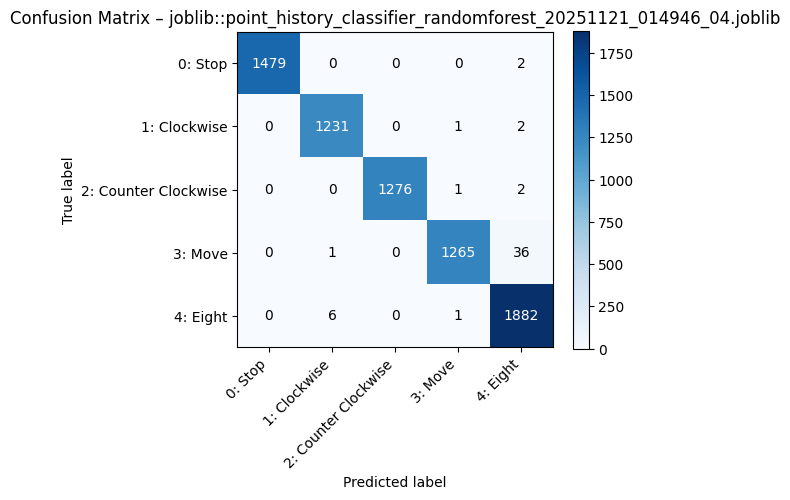

C:\Users\brian\AppData\Local\Temp\ipykernel_2256\1998907906.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


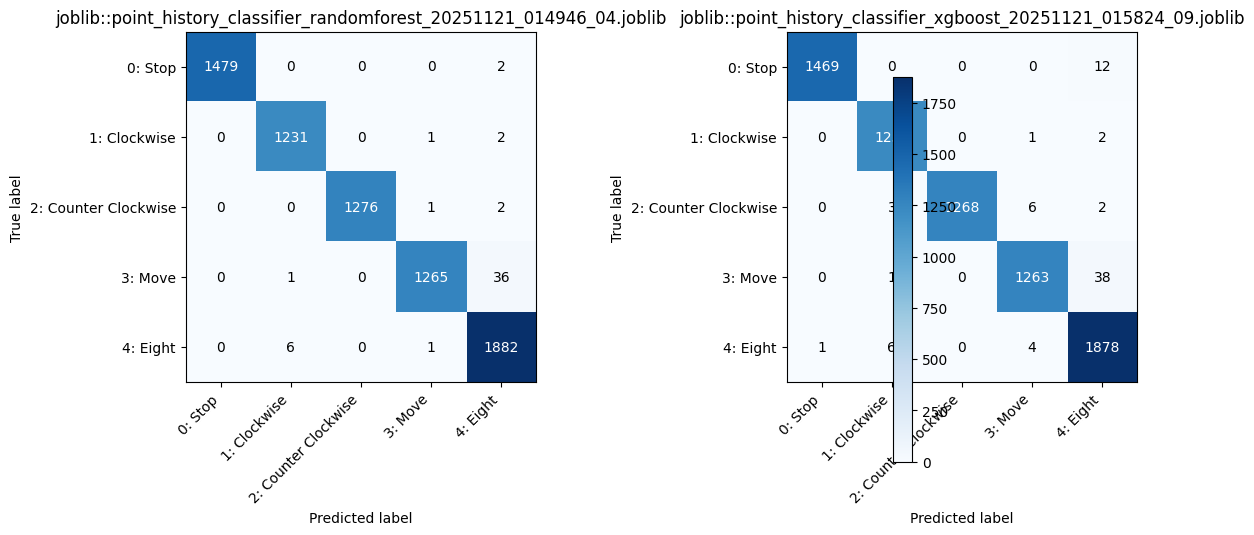

In [107]:
model_a = summary_df["model_name"].iloc[0]
model_b = summary_df["model_name"].iloc[1] if len(summary_df) > 1 else None

print(f"Model A: {model_a}")
print(f"Model B: {model_b}")

res_a = all_results[model_a]
plot_confusion_matrix(res_a["cm"], res_a["label_strings"], title=f"Confusion Matrix – {model_a}")

if model_b is not None:
    res_b = all_results[model_b]
    if np.array_equal(res_a["labels"], res_b["labels"]):
        plot_two_confusion_matrices(
            cm_a=res_a["cm"],
            labels_a=res_a["label_strings"],
            name_a=model_a,
            cm_b=res_b["cm"],
            labels_b=res_b["label_strings"],
            name_b=model_b,
        )
    else:
        print("Labels differ, skip side-by-side comparison.")


In [108]:
best_model_name = summary_df["model_name"].iloc[0]
y_true = all_results[best_model_name]["y_true"]
y_best = all_results[best_model_name]["y_pred"]

rows = []
for name, res in all_results.items():
    if name == best_model_name:
        continue
    y_pred = res["y_pred"]
    chi2_stat, p_value, b, c = mcnemars_test(y_true, y_best, y_pred)
    rows.append({
        "model_name": name,
        "vs_best_model": best_model_name,
        "chi2_stat": chi2_stat,
        "p_value": p_value,
        "b_best_correct_other_wrong": b,
        "c_best_wrong_other_correct": c,
        "significant_at_0.05": (p_value < 0.05) if not np.isnan(p_value) else np.nan,
    })

if rows:
    mcnemar_df = pd.DataFrame(rows).sort_values("p_value")
    print("📈 McNemar's test (difference vs best model):")
    display(mcnemar_df)
else:
    print("Only one model available — McNemar's test needs at least two.")


📈 McNemar's test (difference vs best model):


,model_name,vs_best_model,chi2_stat,p_value,b_best_correct_other_wrong,c_best_wrong_other_correct,significant_at_0.05
0,joblib::point_history_classifier_linearsvc_20251121_014943_00.joblib,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,5477.040857,0.000000e+00,5500,7,True
1,joblib::point_history_classifier_logisticregression_20251121_014943_01.joblib,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,5465.040946,0.000000e+00,5488,7,True
5,tflite::point_history_classifier_mlp_20251121_015029_05.tflite,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,914.379202,7.344841e-201,943,9,True
8,keras::point_history_classifier_lstm_20251121_015250_06.keras,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,564.286441,9.821556e-125,584,6,True
3,joblib::point_history_classifier_svc_rbf_20251121_014945_03.joblib,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,462.168750,1.621572e-102,476,4,True
6,tflite::point_history_classifier_graph_transformer_20251121_015515_07.tflite,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,315.828080,1.173962e-70,341,8,True
2,joblib::point_history_classifier_kneighbors_20251121_014943_02.joblib,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,25.688889,4.011299e-07,40,5,True
7,tflite::point_history_classifier_transformer_self_attention_20251121_015810_08.tflite,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,23.705128,1.122829e-06,61,17,True
4,joblib::point_history_classifier_xgboost_20251121_015824_09.joblib,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,16.531250,4.785484e-05,28,4,True


In [110]:
if GESTURE_GROUPS:
    for group_name, group_ids in GESTURE_GROUPS.items():
        focus_labels = [label_map.get(i, str(i)) for i in group_ids]
        print(f"--- Analysis for {group_name}: {group_ids} -> {focus_labels} ---")

        res = all_results[summary_df["model_name"].iloc[0]]
        mask = np.isin(res["y_true"], group_ids)
        if mask.sum() == 0:
            print("No samples from this group in the dataset.")
            continue

        sim_df = pd.DataFrame({
            "true_id": res["y_true"][mask],
            "pred_id": res["y_pred"][mask],
        })
        sim_df["true_label"] = sim_df["true_id"].map(label_map)
        sim_df["pred_label"] = sim_df["pred_id"].map(label_map)

        pivot_counts = pd.crosstab(sim_df["true_label"], sim_df["pred_label"], dropna=False)
        pivot_rates = pivot_counts.div(pivot_counts.sum(axis=1), axis=0).fillna(0.0)

        print("Counts within group:")
        display(pivot_counts)

        print("Row-normalized confusion (fractions):")
        display(pivot_rates)
else:
    print("No gesture groups configured.")


--- Analysis for Circular: [1, 2, 4] -> ['Clockwise', 'Counter Clockwise', 'Eight'] ---
Counts within group:


pred_label,Clockwise,Counter Clockwise,Eight,Move
true_label,,,,
Clockwise,1231,0,2,1
Counter Clockwise,0,1276,2,1
Eight,6,0,1882,1


Row-normalized confusion (fractions):


pred_label,Clockwise,Counter Clockwise,Eight,Move
true_label,,,,
Clockwise,0.997569,0.000000,0.001621,0.000810
Counter Clockwise,0.000000,0.997654,0.001564,0.000782
Eight,0.003176,0.000000,0.996294,0.000529


--- Analysis for Static_vs_Move: [0, 3] -> ['Stop', 'Move'] ---
Counts within group:


pred_label,Clockwise,Eight,Move,Stop
true_label,,,,
Move,1,36,1265,0
Stop,0,2,0,1479


Row-normalized confusion (fractions):


pred_label,Clockwise,Eight,Move,Stop
true_label,,,,
Move,0.000768,0.02765,0.971582,0.00000
Stop,0.000000,0.00135,0.000000,0.99865


In [111]:
robustness_df = summary_df.copy()
robustness_df["macro_f1_drop_with_noise"] = robustness_df["macro_f1"] - robustness_df["macro_f1_with_noise"]
robustness_df["throughput_per_mb"] = robustness_df["samples_per_second"] / robustness_df["model_disk_mb"].replace({0: np.nan})
robustness_df["efficiency_score"] = robustness_df["macro_f1_with_noise"] * robustness_df["throughput_per_mb"]

print("Robustness and efficiency trade-offs (higher efficiency_score favors compact, fast, robust models):")
display(robustness_df[[
    "model_name",
    "macro_f1",
    "macro_f1_with_noise",
    "macro_f1_drop_with_noise",
    "model_disk_mb",
    "latency_ms_per_sample",
    "throughput_per_mb",
    "efficiency_score",
]].sort_values(by=["efficiency_score", "macro_f1_with_noise"], ascending=False))


Robustness and efficiency trade-offs (higher efficiency_score favors compact, fast, robust models):


,model_name,macro_f1,macro_f1_with_noise,macro_f1_drop_with_noise,model_disk_mb,latency_ms_per_sample,throughput_per_mb,efficiency_score
8,joblib::point_history_classifier_logisticregression_20251121_014943_01.joblib,0.078233,0.076849,0.001384,0.003266,0.000472,6.482711e+08,4.981881e+07
9,joblib::point_history_classifier_linearsvc_20251121_014943_00.joblib,0.077285,0.075160,0.002125,0.003156,0.001121,2.826881e+08,2.124692e+07
7,tflite::point_history_classifier_mlp_20251121_015029_05.tflite,0.865130,0.835780,0.029351,0.006382,0.011891,1.317770e+07,1.101365e+07
1,joblib::point_history_classifier_xgboost_20251121_015824_09.joblib,0.989920,0.698629,0.291291,1.306925,0.002518,3.038679e+05,2.122911e+05
6,keras::point_history_classifier_lstm_20251121_015250_06.keras,0.917978,0.801075,0.116903,0.050328,0.091215,2.178316e+05,1.744994e+05
2,joblib::point_history_classifier_kneighbors_20251121_014943_02.joblib,0.988483,0.950460,0.038023,0.700834,0.009240,1.544286e+05,1.467782e+05
4,tflite::point_history_classifier_graph_transformer_20251121_015515_07.tflite,0.951543,0.893427,0.058116,0.108757,0.062281,1.476341e+05,1.319003e+05
3,tflite::point_history_classifier_transformer_self_attention_20251121_015810_08.tflite,0.986303,0.551718,0.434585,0.216469,0.073735,6.265165e+04,3.456602e+04
5,joblib::point_history_classifier_svc_rbf_20251121_014945_03.joblib,0.931733,0.930845,0.000888,0.604142,0.159203,1.039704e+04,9.678036e+03
0,joblib::point_history_classifier_randomforest_20251121_014946_04.joblib,0.993138,0.829916,0.163222,17.628541,0.016540,3.429694e+03,2.846358e+03


## Notes and Next Steps

- Update `TRAINING_TIME_OVERRIDES` if you have ground-truth training durations (especially for the TFLite exports).
- Adjust `GESTURE_GROUPS`, `NOISE_STD`, or `TOP_K` in the config cell to explore other scenarios.
- Re-run the notebook after training a new model; any `.joblib` or `.tflite` files inside `models/point_history` will be picked up automatically.

## 1. Big picture

We essentially have **three groups of models**:

1. **High-performance, high-quality classifiers**

   * Random Forest, KNN, XGBoost, Transformer Self-Attention, Graph Transformer, SVC-RBF, LSTM
   * Macro F1 (clean) mostly **0.92–0.99+**

2. **“Good enough” but clearly weaker**

   * Tiny TFLite MLP
   * Macro F1 ≈ **0.86**

3. **Very fast but basically unusable as classifiers**

   * Logistic Regression, Linear SVC
   * Macro F1 ≈ **0.07–0.08** (near random)

All models are fast enough for real-time, so the real trade-offs are **accuracy + robustness vs model size vs efficiency metric**.

---

## 2. Raw performance (clean data)

Ordering by **macro_f1** on clean data:

1. **Random Forest** – 0.9931
2. **XGBoost** – 0.9899
3. **KNN** – 0.9885
4. **Transformer Self-Attention (TFLite)** – 0.9863
5. **Graph Transformer (TFLite)** – 0.9515
6. **SVC-RBF** – 0.9317
7. **LSTM (Keras)** – 0.9180
8. **MLP (TFLite)** – 0.8651
   9–10. **Logistic Regression / Linear SVC** – 0.07–0.08

**Takeaways:**

* The task is **very learnable**: several models are effectively “near perfect” on clean test data.
* Classical models (Random Forest, KNN, XGBoost, SVC-RBF) still sit at the top in terms of pure discrimination.
* The two TFLite transformer models land just below the very top, but they’re **much smaller** and deployment-friendly.

If our benchmark is purely “how close to 1.0 can I get?”, Random Forest wins by a hair, followed closely by XGBoost and KNN.

---

## 3. Robustness to noise

Our noise metrics (`macro_f1_with_noise` and `macro_f1_drop_with_noise`) are critical, because real landmark streams are messy.

### Most robust (tiny F1 drop)

* **SVC-RBF**

  * 0.9317 → 0.9308 (drop ≈ 0.0009)
* **Logistic Regression**

  * 0.0782 → 0.0768 (drop ≈ 0.0014 — but already bad)
* **KNN**

  * 0.9885 → 0.9505 (drop ≈ 0.0380; absolute performance still very high)
* **MLP (TFLite)**

  * 0.8651 → 0.8358 (drop ≈ 0.0294)
* **Graph Transformer (TFLite)**

  * 0.9515 → 0.8934 (drop ≈ 0.0581)

### Moderately affected

* **LSTM**

  * 0.9180 → 0.8011 (drop ≈ 0.1169)
* **Random Forest**

  * 0.9931 → 0.8299 (drop ≈ 0.1632)

### Strongly affected

* **XGBoost**

  * 0.9899 → 0.6986 (drop ≈ 0.2913)
* **Transformer Self-Attention**

  * 0.9863 → 0.5517 (drop ≈ 0.4346)

**Interpretation:**

* **KNN, SVC-RBF, Graph Transformer** are our best combination of “high baseline + decent robustness.”

  * KNN remains **~0.95 macro F1 under noise**, which is excellent.
  * SVC-RBF barely changes at all.
  * Graph Transformer sacrifices some F1 but stays solidly high.
* **XGBoost and Transformer SA are fragile**: fantastic on clean data, but they **crash hard** when we perturb the inputs. That’s a red flag if we expect jitter or tracking noise from MediaPipe in the wild.
* Random Forest starts as the absolute best model but loses a lot of quality under noise — still usable, but less impressive.

If we care about “will it still work when the camera is a bit shaky?”, KNN and SVC-RBF are standouts on the classical side, and Graph Transformer is the most attractive of the TFLite models.

---

## 4. Size, latency, and “efficiency” metric

### Model size (disk MB)

* **Tiny (≤ 0.01 MB)**

  * Logistic Regression, Linear SVC (~0.0032 MB)
  * TFLite MLP (~0.0064 MB)
* **Small (0.05–0.25 MB)**

  * LSTM (0.0503)
  * Graph Transformer (0.1088)
  * Transformer SA (0.2165)
* **Medium (0.6–1.3 MB)**

  * SVC-RBF (0.6041)
  * KNN (0.7008)
  * XGBoost (1.3069)
* **Huge**

  * Random Forest (17.63 MB)

### Latency per sample

All are **sub-millisecond**, so latency is not a bottleneck:

* Fastest: Logistic Regression, Linear SVC (microseconds).
* Fast and accurate: XGBoost (0.0025 ms), KNN (0.0092 ms), MLP (0.0119 ms), Random Forest (0.0165 ms).
* Slowest: SVC-RBF (0.1592 ms), but that’s still ~6.3k samples/s — far above real-time needs.

### Efficiency metric

Ranked by our `efficiency_score`:

1. Logistic Regression
2. Linear SVC
3. TFLite MLP
4. XGBoost
5. LSTM
6. KNN
7. Graph Transformer
8. Transformer SA
9. SVC-RBF
10. Random Forest

This metric clearly **favors tiny models with massive throughput_per_mb**, even if their accuracy is terrible. That’s why LR/Linear SVC end up at the top.

**Takeaway:**

* Our efficiency metric is useful to spot “compute/storage cheap” models, but **we must filter by a minimum acceptable macro F1 first**, otherwise LR/LinearSVC look artificially good.
* Among *viable* models (say macro F1 ≥ 0.9), **XGBoost, LSTM, KNN, Graph Transformer** offer the best trade-off of speed/size vs quality, according to that score.

---

## 5. Model-by-model quick notes

* **Random Forest (joblib)**

  * Best macro F1 on clean data.
  * Very large (17.6 MB) and moderately robust.
  * Great if we don’t care about size and want a simple, classical baseline for server-side.

* **KNN (joblib)**

  * Almost as good as Random Forest on clean data.
  * Very robust to noise and still relatively compact (0.7 MB).
  * Good choice for high-accuracy desktop/server deployments; less ideal if memory is extremely tight.

* **XGBoost (joblib)**

  * High accuracy, smallish model, extremely fast.
  * **Big robustness issue**: F1 collapses to ~0.70 with noise.
  * Great for clean or pre-filtered data; more risky in raw real-time pipelines.

* **Transformer Self-Attention (TFLite)**

  * Excellent clean F1 but **very sensitive to noise** (drops to ~0.55).
  * Moderately small (~0.22 MB).
  * Might need better regularization/data augmentation or architectural tweaks.

* **Graph Transformer (TFLite)**

  * Strong overall F1, decent robustness, tiny (0.11 MB).
  * A very attractive **edge-deployment model**: high quality + tiny footprint.

* **SVC-RBF (joblib)**

  * Good F1 and almost no degradation under noise.
  * Slowest of the bunch but still far beyond real-time needs.
  * Solid robust classical option.

* **LSTM (Keras)**

  * Reasonable F1 and good efficiency score.
  * Moderate drop under noise.
  * Makes sense if we want a “sequence-aware” neural model in Keras, but it doesn’t clearly beat the Graph Transformer in this comparison.

* **TFLite MLP**

  * Small, fast, decent F1 but below the main contenders.
  * Might be okay for super-constrained devices, but we can generally do better (Graph Transformer) without much size penalty.

* **Logistic Regression / Linear SVC**

  * Essentially underfitting badly; performance near random.
  * Only interesting as a sanity-check baseline or to validate our efficiency metric.

---

## 6. Recommendations

If we combine accuracy, robustness, size, and simplicity:

* **For edge / mobile (on-device, tiny storage, TFLite)**

  * **Primary pick:** **Graph Transformer (TFLite)**

    * Good macro F1 (~0.95), reasonably robust to noise, ~0.11 MB.
  * **Secondary:** TFLite MLP if we need an even simpler architecture, accepting lower F1.

* **For robust high accuracy on “real” noisy data (server/desktop)**

  * **KNN** or **SVC-RBF**

    * KNN: high accuracy + robust + moderate size.
    * SVC-RBF: slightly lower F1 but exceptionally stable under noise.

* **For clean or well-denoised inputs where noise isn’t a concern**

  * **Random Forest** or **XGBoost**

    * Random Forest gives peak F1.
    * XGBoost gives excellent speed, smaller size, and good efficiency score, but we accept fragility to noise.

* **Not recommended for production**

  * Logistic Regression and Linear SVC (very poor F1).
  * Transformer SA in its current form if we expect noisy landmarks (large performance collapse).

---

## 7. Overall conclusion

* The gesture classification task using MediaPipe finger trajectories is **solved very well** by multiple models; the choice is no longer about “can we classify?” but “which trade-off do we like best?”
* **Classical models still dominate raw accuracy**, especially Random Forest, KNN, and XGBoost.
* **Graph Transformer (TFLite)** stands out as the **best overall deployment candidate**: small, fast, robust enough, and with high macro F1.
* **Our efficiency metric needs to be used alongside a quality threshold**—otherwise, tiny but useless models bubble to the top.
* Going forward, if we want a single “default” model that works well almost everywhere, I’d lean toward:

  * **Graph Transformer (TFLite)** for on-device use, and
  * **KNN or SVC-RBF** for server/desktop pipelines where memory is acceptable and robustness matters.
